In [31]:
import pandas as pd
import re
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

# Как работать

 1. Выбираем необходимые параметры полей в соответсвии с задачей и описанием полей
 2. Нажимаем `cell` -> `Run all`


## Описание параметров (полей)
### Статус 
`lic_status_id`
   * **Параметр не меняется**
   * 1 (действующая) 
   
### Период действия лицензии 
`periodmon`
   * **Параметр определяется пользователем**
   * 1 - 12  выбирается номер месяца
   
`periodyear`
   * **Параметр определяется пользователем**
   * 1999 - 2026  выбирается год
   
### Услуга связи
`service_id`
   * **Параметр определяется пользователем**
   * 1 - Телематические услуги связи
   * 17 - Услуги связи по передаче данных, за исключением услуг связи по передаче данных для целей передачи голосовой информации

### Территория
`region_id`
   * **Параметр не меняется**
   * 77 (Москва) 
   
## P.S. 
Параметры полей **необходимо** заполнить в ячейке ниже, каждое значение обязательно в *кавычках*
При возникновении вопросов, можно навестись мышкой на селектор в выбранном поле и нажать ПКМ -> `Посмотреть код` и в консоли посмотреть возможные значения параметров в поле `option value`
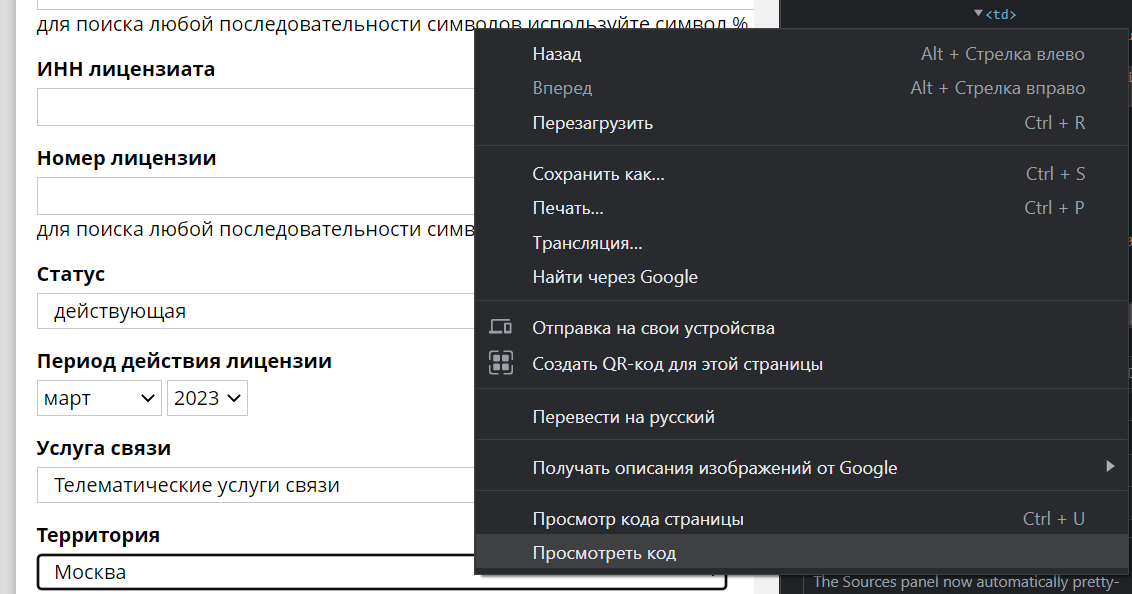
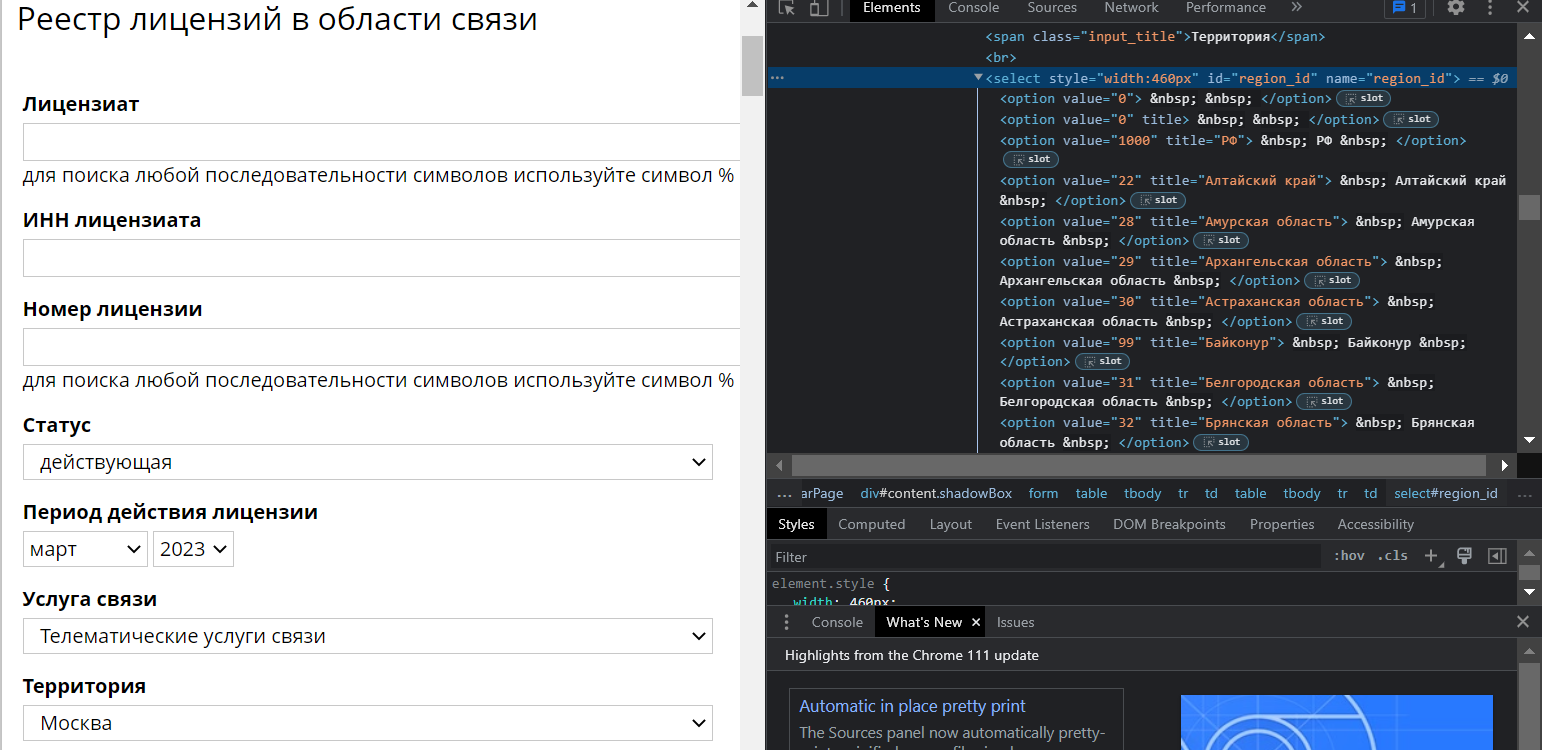

In [32]:
params_tus = {
    'lic_status_id':'1',
    'periodmon': '3',
    'periodyear': '2023',
    'service_id': '1',
    'region_id': '77'
}
params_usppd = {
    'lic_status_id':'1',
    'periodmon': '3',
    'periodyear': '2023',
    'service_id': '17',
    'region_id': '77'
}

In [48]:
def parse_roscomnadzor(params):
    
    '''
    вовзращает список html страницами с сайта Роскомнадзора
    
    params: dict
        словарь со списком параметров
    '''
    # ссылка на сайт Роскомназора
    url = 'https://rkn.gov.ru/communication/register/license/'
    
    list_of_html = []
    
    options = webdriver.ChromeOptions()
    options.add_argument("user-agent=Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:84.0) Gecko/20100101 Firefox/84.0")
    options.add_argument("--disable-blink-features=AutomationControlled")

    s = Service(executable_path="chromedriver.exe")
    driver = webdriver.Chrome(service=s, options=options)

    try:
        driver.get(url)
        time.sleep(1)

        # выбираем из списка необходимые параметры
        for key in params:
            select_element = driver.find_element(By.NAME, key)
            select = Select(select_element)
            select.select_by_value(params[key])

        # нажимаем на кнопку "Найти"
        element = driver.find_element(By.CLASS_NAME, 'buttonSearch')
        element.click()

        # считаем кол-во записей, чтобы определить кол-во страниц
        num_elements = driver.find_element(By.XPATH, "//p[b = 'Всего:']").text
        num_pages = int(re.findall('[0-9]+', num_elements)[0])//100

        # выгружаем первую страницу
        html_page = driver.page_source
        list_of_html.append(html_page)

        # здесь дальше идет цикл по страницам
        p = 0
        for i in range(num_pages):
            p += 100

            driver.get(url + f'/p{p}')
            html_page_i = driver.page_source
            list_of_html.append(html_page_i)

    except Exception as ex:
        print(ex)
    finally:
        driver.close()
        driver.quit()
        
    return list_of_html

In [34]:
def get_df(list_of_html):
    
    '''
    вовзращает датафрейм на основе html-страниц
    
    list_of_html: list
        список с html-страницами
    '''
    
    df_all = pd.DataFrame()

    for html in list_of_html:
        df = pd.read_html(html)[11]
        df_all = pd.concat([df_all, df]).reset_index(drop=True)

    df_all = df_all.drop_duplicates().reset_index(drop=True)
    df_all['ИНН'] = df_all['Лицензиат'].apply(lambda x: re.findall('[0-9]+', x)[-1])
    
    return df_all

In [49]:
# выгружаем страницы с данными по каждому запросу
list_of_html_tus = parse_roscomnadzor(params_tus)
list_of_html_usppd = parse_roscomnadzor(params_usppd)

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://chromedriver.chromium.org/home


In [36]:
# создаем таблицу по каждой выгрузке
df_tus = get_df(list_of_html_tus)
df_usppd = get_df(list_of_html_usppd)

In [37]:
# объединяем в 1 тублицу и удаляем дубликаты
df_concated = pd.concat([df_tus,df_usppd])
df_concated = df_concated.drop_duplicates(subset='ИНН').reset_index(drop=True)

In [38]:
def count_nko(row):
    
    '''
    возвращает ДА, если организация входит в перечень
               НЕТ, если организация не входит в перечень
    
    row: list
        строка в датафрейме
    '''
    
    
    row = row.lower()
    if 'унитарн' in row:
        return 'да'
    elif 'муниципальное бюджетное' in row:
        return 'да'
    elif 'федеральное бюджетное' in row:
        return 'да'
    elif 'казен' in row:
        return 'да'
    elif 'Федеральное государственное бюджетное' in row:
        return 'да'
    elif 'Федеральное государственное учреждение' in row:
        return 'да'
    else:
        return 'нет'

In [39]:
df_concated['НКО'] = df_concated['Лицензиат'].apply(count_nko)

In [40]:
num_org = len(df_concated['НКО'])
num_nko = df_concated['НКО'].value_counts()['да']

In [41]:
report = f'''По состоянию на конец {params_tus['periodmon']} {params_tus['periodyear']} в городе Москве
в перечень организаций в сфере предоставления 
широкополосного доступа к сети Интернет {num_org} лицензиата, 
в том числе {num_nko} из них являются некоммерческими организациями, 
в соответствии с реестром лицензий в области связи, размещенным на сайте Федеральной службы по надзору в сфере связи, 
информационных технологий и массовых коммуникаций, в категориях «телематические услуги связи» и 
«услуги связи по передаче данных, за исключением услуг связи по передаче данных для целей передачи голосовой информации».'''


### Скопируйте отчет

In [42]:
print(report.replace(u'\n', u''))

По состоянию на конец 3 2023 в городе Москвев перечень организаций в сфере предоставления широкополосного доступа к сети Интернет 3566 лицензиата, в том числе 15 из них являются некоммерческими организациями, в соответствии с реестром лицензий в области связи, размещенным на сайте Федеральной службы по надзору в сфере связи, информационных технологий и массовых коммуникаций, в категориях «телематические услуги связи» и «услуги связи по передаче данных, за исключением услуг связи по передаче данных для целей передачи голосовой информации».


### Загрузите результат в Excel-файл

In [43]:
# при необходимости можно дописать путь сохранения excel-файла, для этого перед "Лицензии" укажите путь до папки
with pd.ExcelWriter(f"Лицензии_{params_tus['periodmon']}_{params_tus['periodyear']}.xlsx") as writer:

    df_tus.to_excel(writer, sheet_name="ТУС", index=False)
    df_usppd.to_excel(writer, sheet_name="УСпПД", index=False)
    df_concated.to_excel(writer, sheet_name="ТУС+УСпПД", index=False)
